In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests


from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [5]:
stock_price = pd.DataFrame() # 주가 데이터를 저장할 DataFrame

In [3]:
stock_number = "035420"
pages = 50


In [6]:
for page in range(1, pages+1):
    url = f'https://finance.naver.com/item/sise_day.nhn?code={stock_number}&page={page}'
    headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36'}
    response = requests.get(url, headers=headers)
    time.sleep(0.5)
    html = BeautifulSoup(response.text, "lxml")

    table = html.select("table")

    juga = pd.read_html(str(table))
    juga = juga[0].dropna()
    stock_price = pd.concat([stock_price,juga], axis=0)

In [61]:
stock_price = stock_price.reset_index(drop = True)
stock_price.tail()

,날짜,종가,전일비,시가,고가,저가,거래량
495,2019-10-31,164000.0,9500.0,159000.0,167000.0,157500.0,1409619.0
496,2019-10-30,154500.0,1500.0,152000.0,154500.0,151500.0,290658.0
497,2019-10-29,153000.0,4000.0,157500.0,158000.0,152000.0,321007.0
498,2019-10-28,157000.0,4500.0,152500.0,158000.0,152500.0,335238.0
499,2019-10-25,152500.0,500.0,151000.0,153500.0,151000.0,162510.0


In [62]:
stock_price["날짜"] = pd.to_datetime(stock_price["날짜"])
stock_price["날짜"].head(5)

0   2021-11-02
1   2021-11-01
2   2021-10-29
3   2021-10-28
4   2021-10-27
Name: 날짜, dtype: datetime64[ns]

### Visualization 종가 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_te

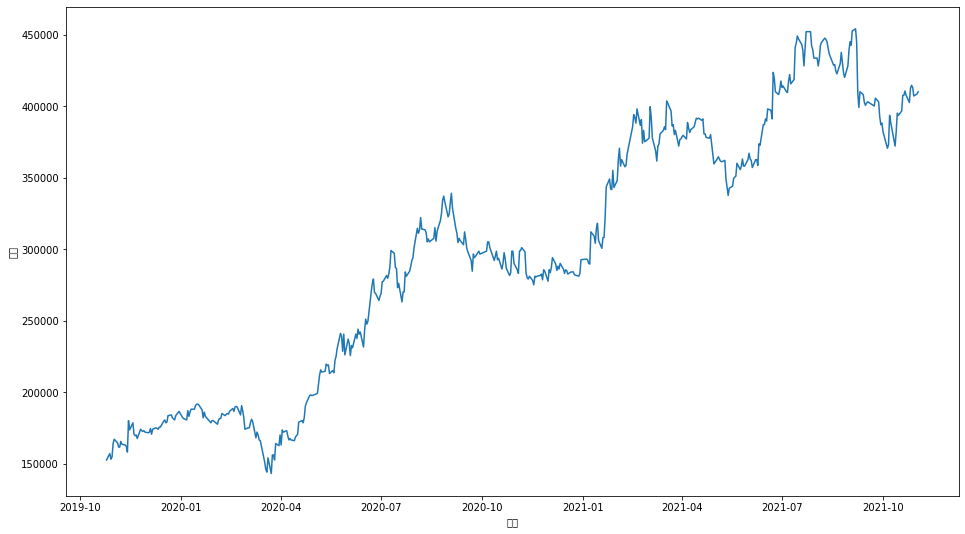

In [63]:
plt.figure(figsize = (16,9))
sns.lineplot(x = stock_price['날짜'],y = stock_price['종가'])
plt.show()

### Data Normalization

In [64]:
scaler = MinMaxScaler()
scale_cols = ['시가','고가','저가','거래량']
scaled = scaler.fit_transform(stock_price[scale_cols])
scaled_stock = pd.DataFrame(scaled)
scaled_stock.head()

,0,1,2,3
0,0.841444,0.839937,0.864353,0.059531
1,0.833595,0.830428,0.848580,0.055560
2,0.852433,0.839937,0.853312,0.098544
3,0.871272,0.855784,0.872240,0.105766
4,0.858713,0.854200,0.872240,0.106513


In [65]:
scaled_stock.columns = scale_cols
scaled_stock.head()

,시가,고가,저가,거래량
0,0.841444,0.839937,0.864353,0.059531
1,0.833595,0.830428,0.848580,0.055560
2,0.852433,0.839937,0.853312,0.098544
3,0.871272,0.855784,0.872240,0.105766
4,0.858713,0.854200,0.872240,0.106513


In [66]:
end_price = np.log1p(stock_price['종가']) # 종가 정규화
end_price[:10]

0    12.923915
1    12.920250
2    12.916571
3    12.931205
4    12.934831
5    12.929994
6    12.905453
7    12.917799
8    12.925134
9    12.917799
Name: 종가, dtype: float64

In [67]:
scaled_stock['종가'] = end_price
scaled_stock.head()

,시가,고가,저가,거래량,종가
0,0.841444,0.839937,0.864353,0.059531,12.923915
1,0.833595,0.830428,0.848580,0.055560,12.920250
2,0.852433,0.839937,0.853312,0.098544,12.916571
3,0.871272,0.855784,0.872240,0.105766,12.931205
4,0.858713,0.854200,0.872240,0.106513,12.934831


### Train_test split

In [68]:
train = scaled_stock[:-30]
test = scaled_stock[-30:]
print(np.shape(train), np.shape(test))

(470, 5) (30, 5)


### Data Loader

In [91]:
def make_dataset(data,label,window_size = 20):
  feature_list = []
  label_list = []

  for i in range(len(data)-window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))

  return np.array(feature_list), np.array(label_list)

In [92]:
train_features = train[['시가','고가','저가','거래량']]
train_label = train['종가']

test_features = test[['시가','고가','저가','거래량']]
test_label = test['종가']

print(np.shape(train_features), np.shape(train_label))
print(np.shape(test_features), np.shape(test_label))

(470, 4) (470,)
(30, 4) (30,)


In [93]:
train_feature, train_label = make_dataset(train_features, train_label, 10)

# train, validation set 생성
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label,test_size =0.2)

# test_dataset 생성
test_feature, test_label = make_dataset(test_features, test_label,10)

In [72]:
train_feature.shape[1], train_feature.shape[2]

(10, 4)

In [73]:
train_feature.shape

(460, 10, 4)

In [85]:
test_feature.shape, test_label.shape

((20, 10, 4), (20, 10))

In [36]:
model = keras.Sequential([
                          keras.layers.LSTM(16, input_shape = (10,4),activation = 'relu'),
                          keras.layers.Dense(1)
])

In [38]:
model.compile(optimizer='adam' ,  loss= 'mse')

In [48]:
epoch = 500
batch_size = 64
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience= 7)
cp = keras.callbacks.ModelCheckpoint('/content/model/predict_stock_2.h5',monitor = 'val_loss',save_best_only = True)

history = model.fit(x_train,y_train,
                    epochs = epoch,
                    batch_size = batch_size,
                    validation_data = (x_valid,y_valid),
                    callbacks = [es,cp])

Epoch 1/500
6/6 [==============================] - 0s 53ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 2/500
6/6 [==============================] - 0s 41ms/step - loss: 0.0104 - val_loss: 0.0122
Epoch 3/500
6/6 [==============================] - 0s 44ms/step - loss: 0.0106 - val_loss: 0.0127
Epoch 4/500
6/6 [==============================] - 0s 52ms/step - loss: 0.0099 - val_loss: 0.0112
Epoch 5/500
6/6 [==============================] - 0s 53ms/step - loss: 0.0101 - val_loss: 0.0125
Epoch 6/500
6/6 [==============================] - 0s 50ms/step - loss: 0.0103 - val_loss: 0.0109
Epoch 7/500
6/6 [==============================] - 0s 47ms/step - loss: 0.0096 - val_loss: 0.0105
Epoch 8/500
6/6 [==============================] - 0s 43ms/step - loss: 0.0099 - val_loss: 0.0147
Epoch 9/500
6/6 [==============================] - 0s 48ms/step - loss: 0.0113 - val_loss: 0.0135
Epoch 10/500
6/6 [==============================] - 0s 47ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 11/500
6/6 [=

# Test Model

In [40]:
loaded_models = keras.models.load_model('/content/model/predict_stock_2.h5')

In [94]:
pred = model.predict(test_feature)

pred = np.expm1(pred)  # log scale 원상복귀

In [95]:
pred.shape

(20, 1)

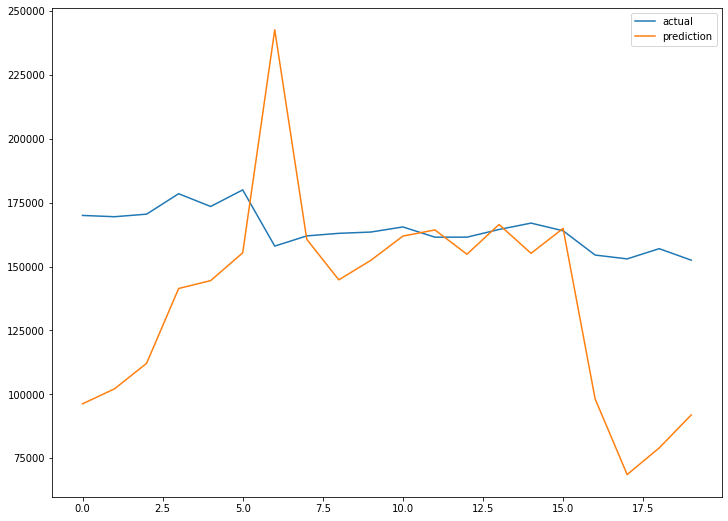

In [96]:
plt.figure(figsize = (12,9))
plt.plot(np.expm1(test_label),label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [60]:
test_label.shape

(20, 10)